### Task 1

In [8]:
import nltk
import os
import re
import numpy as np

In [9]:
corpus = "./nasa"
all_files = os.listdir(corpus)

articles = []
all_articles = []
count = 0

all_keys = []
keys = []

for file in all_files:
    if file.endswith('.txt'):
        all_articles.append(file)
    if file.endswith('.key'):
        all_keys.append(file)
            
all_articles = sorted(all_articles)
all_keys = sorted(all_keys)
articles = all_articles[:15]
keys = all_keys[:15]

In [10]:
tokenized_text = []

for file_name in articles:
    file_path = os.path.join(corpus, file_name)
    with open(file_path, 'r', encoding="latin-1") as file:
        text = file.read()
        cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        tokens = cleaned_text.split()
        tokenized_text.append(tokens)

### Task 2

In [11]:
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [12]:
nltk.download('punkt')
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /Users/ashnadua/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
stemmed_tokenized = []

for tokens in tokenized_text:
    stems = []
    for token in tokens:
        st = stemmer.stem(token)
        stems.append(st)
    stemmed_tokenized.append(stems)

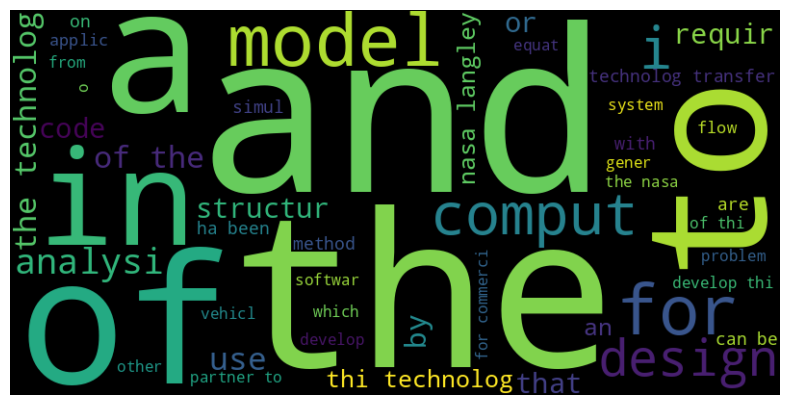

In [14]:
flat_tokens = []

for tokens in stemmed_tokenized:
    for token in tokens:
        flat_tokens.append(token)
        
text = ' '.join(flat_tokens)

wordcloud = WordCloud(
    width=800, height=400, max_words=50, stopwords=[]
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
from nltk import FreqDist

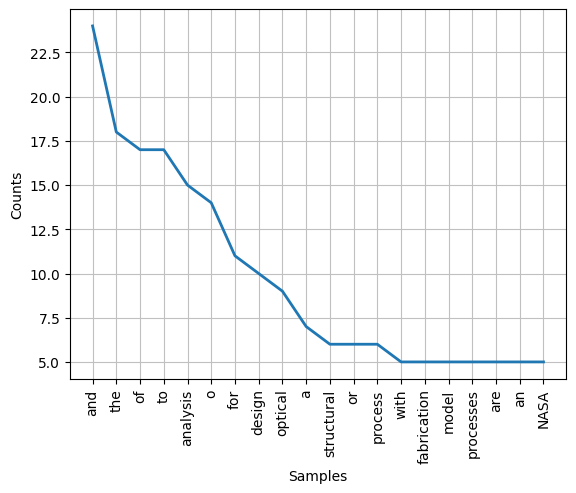

In [16]:
first_article_tokens = tokenized_text[0]
freq_dist = FreqDist(first_article_tokens)

freq_dist.plot(20, cumulative=False)
plt.show()

### Task 3

In [35]:
from collections import Counter
import math
from matplotlib_venn import venn2

In [18]:
tokenize_all_files = []

for file_name in all_articles:
    file_path = os.path.join(corpus, file_name)
    with open(file_path, 'r', encoding="latin-1") as file:
        text = file.read()
        cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        tokens = cleaned_text.split()
        tokenize_all_files.append(tokens)

In [19]:
stemmed_all_files = []

for tokens in tokenize_all_files:
    stems = []
    for token in tokens:
        st = stemmer.stem(token)
        stems.append(st)
    stemmed_all_files.append(stems)

In [25]:
num = len(all_articles)
p = 20

In [26]:
# tf calculation
tf_values = []

for stemmed_doc in stemmed_all_files:
    max_term_freq = max(Counter(stemmed_doc).values())
    term_freq = {term: freq / max_term_freq for term, freq in Counter(stemmed_doc).items()}
    
    tf_values.append(term_freq)

In [27]:
# tfidf calculation
tfidf_values = []

for doc in tf_values:
    tfidf_curr = {}

    for term, tf in doc.items():
        ni = sum(1 for d in tf_values if term in d)
        if ni > 0:
            idf = math.log(num / ni)
        else:
            idf = 0.0
        tfidf_val = tf * idf
        tfidf_curr[term] = tfidf_val

    tfidf_values.append(tfidf_curr)

In [28]:
top_stems_tf = []

for doc in tf_values:
    top_terms = sorted(doc.items(), key=lambda x: x[1], reverse=True)[:p]
    top_stems_tf.append([term for term, _ in top_terms])

In [29]:
top_stems_tfidf = []

average_tfidf = {}
for doc in tfidf_values:
    for term, tfidf in doc.items():
        if term in average_tfidf:
            average_tfidf[term] += tfidf
        else:
            average_tfidf[term] = tfidf

for term, total_tfidf in average_tfidf.items():
    average_tfidf[term] = total_tfidf / num

for doc in tfidf_values:
    top_terms = sorted(doc.items(), key=lambda x: x[1], reverse=True)[:p]
    top_stems_tfidf.append([term for term, _ in top_terms])

In [32]:
# Flatten the list of top stems from all documents
all_top_stems_tf = [stem for stems in top_stems_tf for stem in stems]
all_top_stems_tfidf = [stem for stems in top_stems_tfidf for stem in stems]

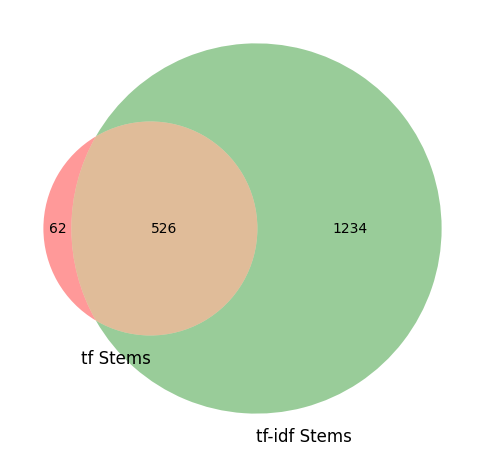

In [37]:
set_stems_tf = set(all_top_stems_tf)
set_stems_tfidf = set(all_top_stems_tfidf)

plt.figure(figsize=(6, 6))
venn2([set_stems_tf, set_stems_tfidf], ('tf Stems', 'tf-idf Stems'))
plt.show()

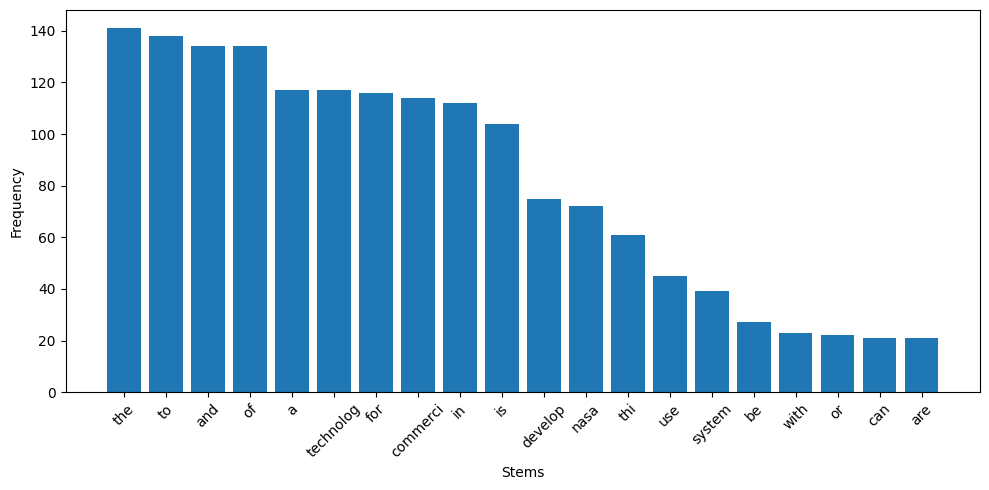

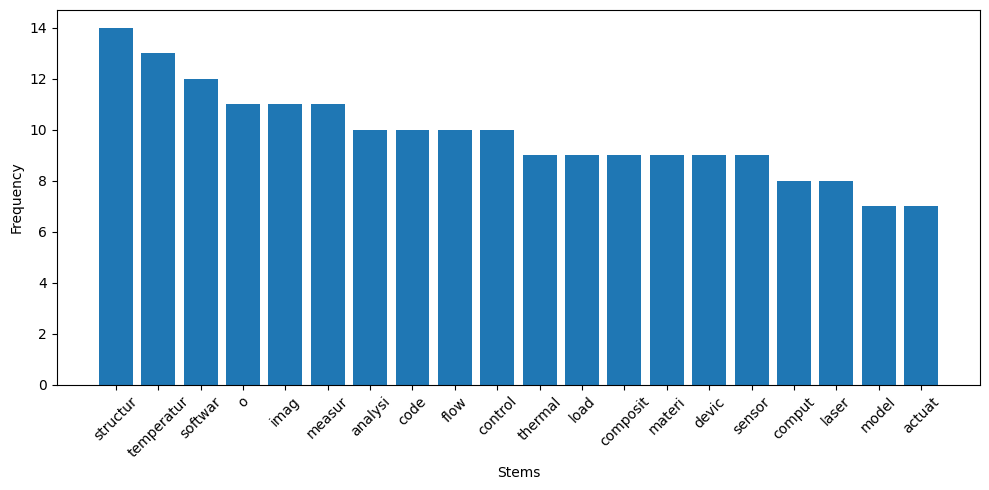

In [38]:
common_stems_tf = Counter(all_top_stems_tf)
common_stems_tfidf = Counter(all_top_stems_tfidf)

top_common_stems_tf = common_stems_tf.most_common(20)
top_common_stems_tfidf = common_stems_tfidf.most_common(20)

stem_labels_tf, stem_counts_tf = zip(*top_common_stems_tf)
plt.figure(figsize=(10, 5))
plt.bar(stem_labels_tf, stem_counts_tf)
plt.xlabel('Stems')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

stem_labels_tfidf, stem_counts_tfidf = zip(*top_common_stems_tfidf)
plt.figure(figsize=(10, 5))
plt.bar(stem_labels_tfidf, stem_counts_tfidf)
plt.xlabel('Stems')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Term Document Matrix - Boolean Model

In [39]:
class BooleanModel:
    def __init__(self, top_stems):
        self.top_stems = top_stems
        self.term_to_index = {}
        self.matrix = None
        self._create_matrix()
        
    def _create_matrix(self):
        unique_stems = set()
        for stem in self.top_stems:
            unique_stems.update(stem)
            
        num = len(unique_stems)
        num_docs = len(self.top_stems)
        self.matrix = np.zeros((num, num_docs), dtype=int)
        
        for index, stem in enumerate(self.top_stems):
            for term in stem:
                term_index = self.term_to_index.get(term, -1)
                if term_index == -1:
                    term_index = len(self.term_to_index)
                    self.term_to_index[term] = term_index
                self.matrix[term_index, index] = 1
                
    def _boolean_and(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.ones(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result &= self.matrix[term_index, :]
        else:
            result = np.zeros(self.matrix.shape[1], dtype=int)
            
        return result
    
    def _boolean_or(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.zeros(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result |= self.matrix[term_index, :]
        else:
            return np.zeros(self.matrix.shape[1], dtype=int)
            
        return result
    
    def _boolean_not(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.ones(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result &= ~self.matrix[term_index, :]
        else:
            return np.zeros(self.matrix.shape[1], dtype=int)
        
        return result
    
    def query(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        query_terms = query.lower().split()
        result = None
        i = 0
        
        while i < len(query_terms):
            term = query_terms[i]
            term = stemmer.stem(term)
            
            if term == "and":
                i += 1
                if result is None:
                    result = self._boolean_and(query_terms[i])
                else:
                    result &= self._boolean_and(query_terms[i])
                    
            elif term == "or":
                i += 1
                if result is None:
                    result = self._boolean_or(query_terms[i])
                else:
                    result |= self._boolean_or(query_terms[i])
                    
            elif term == "not":
                i += 1
                if result is None:
                    result = self._boolean_not(query_terms[i])
                else:
                    result &= self._boolean_not(query_terms[i])
                    
            else:
                if result is None:
                    result = self._boolean_and(term)
                else:
                    result &= self._boolean_and(term)
                    
            i += 1
            
        doc_names = []
        for index, value in enumerate(result):
            if value == 1:
                doc_names.append(all_articles[index])
                
        return doc_names

In [40]:
class BooleanModelStopWords:
    def __init__(self, top_stems):
        self.top_stems = top_stems
        self.term_to_index = {}
        self.matrix = None
        self._create_matrix()
        
    def _create_matrix(self):
        unique_stems = set()
        for stem in self.top_stems:
            unique_stems.update(stem)
            
        num = len(unique_stems)
        num_docs = len(self.top_stems)
        self.matrix = np.zeros((num, num_docs), dtype=int)
        
        for index, stem in enumerate(self.top_stems):
            for term in stem:
                term_index = self.term_to_index.get(term, -1)
                if term_index == -1:
                    term_index = len(self.term_to_index)
                    self.term_to_index[term] = term_index
                self.matrix[term_index, index] = 1
                
    def _boolean_and(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.ones(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result &= self.matrix[term_index, :]
            
        return result
    
    def _boolean_or(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.zeros(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result |= self.matrix[term_index, :]
            
        return result
    
    def _boolean_not(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        result = np.ones(self.matrix.shape[1], dtype=int)
        
        term_index = self.term_to_index.get(query, -1)
        if term_index != -1:
            result &= ~self.matrix[term_index, :]
        
        return result
    
    def query(self, query):
        if self.matrix is None:
            raise ValueError("Matrix is not yet created.")
            
        query_terms = query.lower().split()
        result = None
        i = 0
        
        stop_words = set()
        with open("english.stop", 'r', encoding="latin-1") as file:
            self.stop_words = set(file.read().split())
        
        while i < len(query_terms):
            term = query_terms[i]
            term = stemmer.stem(term)
            
            if term == "and":
                i += 1
                if result is None:
                    result = self._boolean_and(query_terms[i])
                else:
                    result &= self._boolean_and(query_terms[i])
                    
            elif term == "or":
                i += 1
                if result is None:
                    result = self._boolean_or(query_terms[i])
                else:
                    result |= self._boolean_or(query_terms[i])
                    
            elif term == "not":
                i += 1
                if result is None:
                    result = self._boolean_not(query_terms[i])
                else:
                    result &= self._boolean_not(query_terms[i])
                    
            else:
                if term not in stop_words:
                    if result is None:
                        result = self._boolean_and(term)
                    else:
                        result &= self._boolean_and(term)
                        
            i += 1
        
        doc_names = []
        for index, value in enumerate(result):
            if value == 1:
                doc_names.append(all_articles[index])
                
        return doc_names

### Term Document Matrix - Vector Model

In [41]:
class VectorModel:
    def __init__(self, top_stems):
        self.top_stems = top_stems
        self.term_to_index = {}
        self.matrix = None
        self.idf_values = {}
        self.stemmer = PorterStemmer()
        self.create_matrix()
        
    def create_matrix(self):
        unique_stems = set()
        for stem in self.top_stems:
            unique_stems.update(stem)
            
        num = len(unique_stems)
        num_docs = len(self.top_stems)
        self.matrix = np.zeros((num, num_docs), dtype=float)
        
        doc_freq = Counter()
        max_term_freq = Counter()

        for index, stem in enumerate(self.top_stems):
            term_freq = Counter(stem)
            max_freq = max(term_freq.values())

            for term, freq in term_freq.items():
                doc_freq[term] += 1
                max_term_freq[index] = max(max_term_freq[index], freq)

        for term, df in doc_freq.items():
            self.idf_values[term] = math.log(num_docs / df)
        
        for index, stem in enumerate(self.top_stems):
            term_freq = Counter(stem)
            
            for term, freq in term_freq.items():
                term_index = self.term_to_index.get(term, -1)
                if term_index == -1:
                    term_index = len(self.term_to_index)
                    self.term_to_index[term] = term_index
    
                tf = freq / max_term_freq[index]
                idf = self.idf_values.get(term, 0.0)
                self.matrix[term_index, index] = tf * idf
        
    def create_query_vector(self, query):
        if self.matrix is None:
            self.create_matrix()

        query_terms = query.lower().split()
        query_vector = np.zeros((self.matrix.shape[0],), dtype=float)

        term_freq_in_query = Counter(query_terms)

        for term in query_terms:
            stemmed_term = self.stemmer.stem(term)
            term_index = self.term_to_index.get(stemmed_term, -1)
            if term_index != -1 and term_index < len(query_vector):
                tf = term_freq_in_query[term]
                idf = self.idf_values.get(stemmed_term, 0.0)
                query_vector[term_index] = tf * idf
        return query_vector
    
    def cosine_similarity(self, query_vector, doc_vector):
        dot_prod = np.dot(query_vector, doc_vector)
        query_norm = np.linalg.norm(query_vector)
        doc_norm = np.linalg.norm(doc_vector)

        if query_norm != 0 and doc_norm != 0:
            return dot_prod / (query_norm * doc_norm)
        else:
            return 0.0

    def query(self, query):
        if self.matrix is None:
            self.create_matrix()
    
        query = query.lower()
        query_vector = self.create_query_vector(query)
        similarities = []

        for index in range(self.matrix.shape[1]):
            doc_vector = self.matrix[:, index]
            similarity = self.cosine_similarity(query_vector, doc_vector)
    
            if similarity != 0:
                similarities.append((index, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)
        
        doc_names = []
        for index, a in similarities:
            doc_names.append(all_articles[index])
        return doc_names

In [1286]:
class VectorModelStopWords:
    def __init__(self, top_stems):
        self.top_stems = top_stems
        self.term_to_index = {}
        self.matrix = None
        self.idf_values = {}
        self.stemmer = PorterStemmer()
        self.create_matrix()
        
    def create_matrix(self):
        unique_stems = set()
        for stem in self.top_stems:
            unique_stems.update(stem)
            
        num = len(unique_stems)
        num_docs = len(self.top_stems)
        self.matrix = np.zeros((num, num_docs), dtype=float)
        
        doc_freq = Counter()
        max_term_freq = Counter()

        for index, stem in enumerate(self.top_stems):
            term_freq = Counter(stem)
            max_freq = max(term_freq.values())

            for term, freq in term_freq.items():
                doc_freq[term] += 1
                max_term_freq[index] = max(max_term_freq[index], freq)

        for term, df in doc_freq.items():
            self.idf_values[term] = math.log(num_docs / df)
        
        for index, stem in enumerate(self.top_stems):
            term_freq = Counter(stem)
            
            for term, freq in term_freq.items():
                term_index = self.term_to_index.get(term, -1)
                if term_index == -1:
                    term_index = len(self.term_to_index)
                    self.term_to_index[term] = term_index
    
                tf = freq / max_term_freq[index]
                idf = self.idf_values.get(term, 0.0)
                self.matrix[term_index, index] = tf * idf
        
    def create_query_vector(self, query):
        if self.matrix is None:
            self.create_matrix()
        
        stop_words = set()
        with open('english.stop', 'r', encoding="latin-1") as file:
            stop_words = set(file.read().split())

        query_terms = query.lower().split()
        filtered_query_terms = []
    
        for term in query_terms:
            stemmed_term = self.stemmer.stem(term)
            if stemmed_term not in stop_words:
                filtered_query_terms.append(stemmed_term)

        query_vector = np.zeros((self.matrix.shape[0],), dtype=float)
        term_freq_in_query = Counter(filtered_query_terms)

        for term, tf in term_freq_in_query.items():
            term_index = self.term_to_index.get(term, -1)
            if term_index != -1 and term_index < len(query_vector):
                idf = self.idf_values.get(term, 0.0)
                query_vector[term_index] = tf * idf
        return query_vector

    
    def cosine_similarity(self, query_vector, doc_vector):
        dot_prod = np.dot(query_vector, doc_vector)
        query_norm = np.linalg.norm(query_vector)
        doc_norm = np.linalg.norm(doc_vector)

        if query_norm != 0 and doc_norm != 0:
            return dot_prod / (query_norm * doc_norm)
        else:
            return 0.0

    def query(self, query):
        if self.matrix is None:
            self.create_matrix()
    
        query = query.lower()
        query_vector = self.create_query_vector(query)
        similarities = []

        for index in range(self.matrix.shape[1]):
            doc_vector = self.matrix[:, index]
            similarity = self.cosine_similarity(query_vector, doc_vector)
    
            if similarity != 0:
                similarities.append((index, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)
        doc_names = []
        for index, a in similarities:
            doc_names.append(all_articles[index])
        return doc_names

In [44]:
boolean_model = BooleanModel(top_stems_tf)
vector_model = VectorModel(top_stems_tf)

In [50]:
queries = ["technology", "space or mission", "nasa tools", "fluid"]
top_k = 20

num_queries = 4
num_cols = 2
num_rows = 2
boolean_results = []
vector_results = []

for query in queries:
    boolean_rankings = boolean_model.query(query)[:top_k]
    vector_rankings = vector_model.query(query)[:top_k]

    boolean_results.append(len(boolean_rankings))
    vector_results.append(len(vector_rankings))

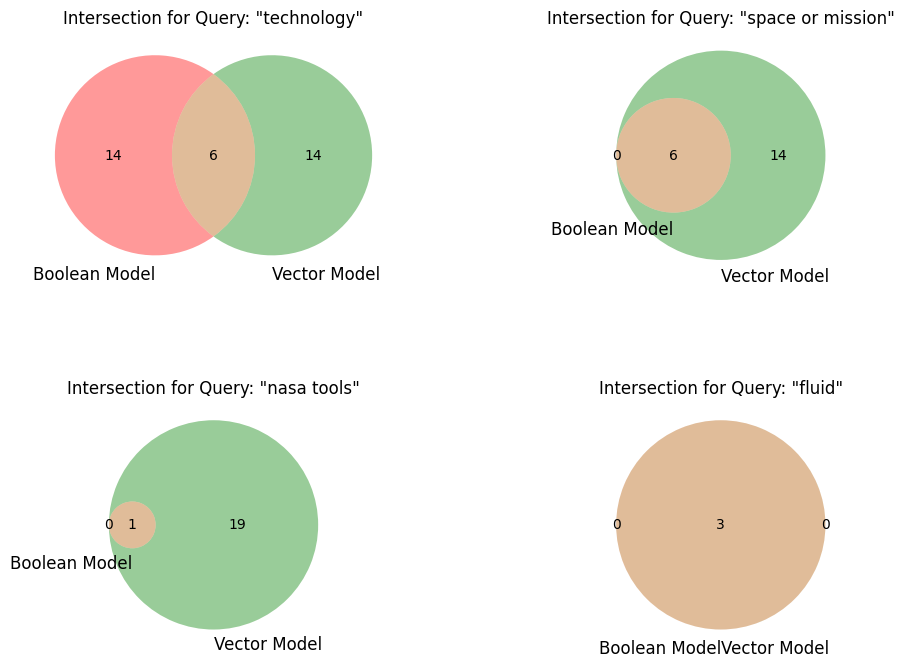

In [51]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, query in enumerate(queries):
    boolean_rankings = set(boolean_model.query(query)[:top_k])
    vector_rankings = set(vector_model.query(query)[:top_k])

    row_idx = i // num_cols
    col_idx = i % num_cols

    venn2([boolean_rankings, vector_rankings], ('Boolean Model', 'Vector Model'), ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Intersection for Query: "{query}"')

for i in range(num_queries, num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])
plt.show()

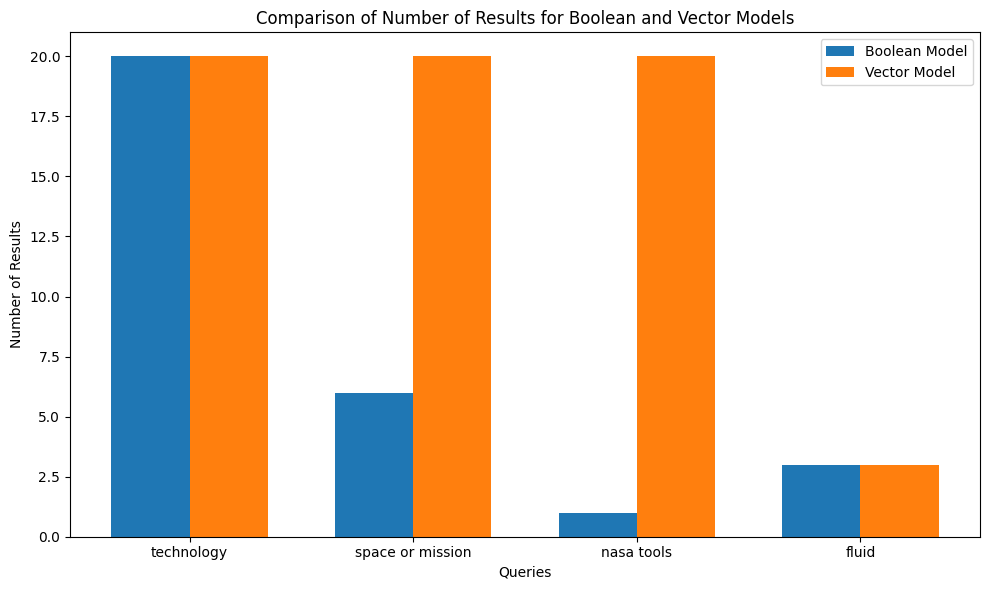

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(num_queries)

bar1 = ax.bar(index, boolean_results, bar_width, label='Boolean Model')
bar2 = ax.bar([i + bar_width for i in index], vector_results, bar_width, label='Vector Model')

ax.set_xlabel('Queries')
ax.set_ylabel('Number of Results')
ax.set_title('Comparison of Number of Results for Boolean and Vector Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(queries)
ax.legend()

plt.tight_layout()
plt.show()

### Task 5

In [53]:
stop_file = "english.stop"
stop_words = set()

with open(stop_file, 'r', encoding="latin-1") as file:
    stop_words = set(file.read().split())
    
filtered_tokens = []
for tokens in tokenize_all_files:
    filter_mid = []
    for token in tokens:
        if token.lower() not in stop_words:
            filter_mid.append(token)
    filtered_tokens.append(filter_mid)
            
filtered_stems = []
for tokens in filtered_tokens:
    mid = []
    for token in tokens:
        mid.append(stemmer.stem(token))
    filtered_stems.append(mid)

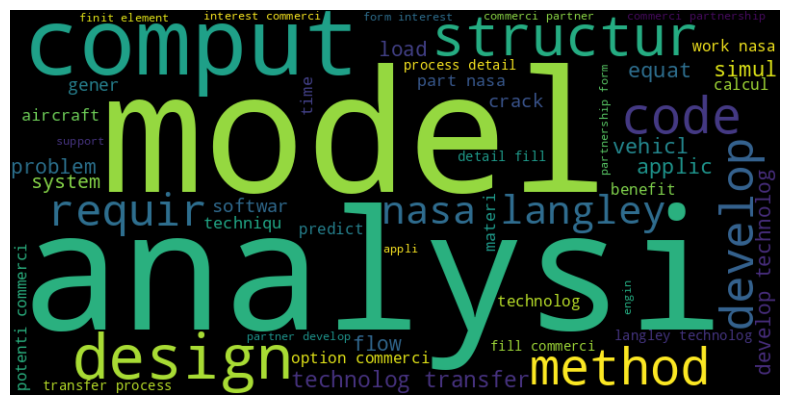

In [54]:
flat_filtered_stems = []

for tokens in filtered_stems[:15]:
    for token in tokens:
        flat_filtered_stems.append(token)
        
text = ' '.join(flat_filtered_stems)

wordcloud = WordCloud(
    width=800, height=400, max_words=50, stopwords=[]
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("word.png")
plt.show()

In [55]:
# tf calculation for filtered stems
filtered_tf_values = []

for stemmed_doc in filtered_stems:
    max_term_freq = max(Counter(stemmed_doc).values())
    term_freq = {term: freq / max_term_freq for term, freq in Counter(stemmed_doc).items()}
    
    filtered_tf_values.append(term_freq)

In [56]:
#tf-idf calculation for filtered_stems
filtered_tfidf_values = []

for doc in filtered_tf_values:
    tfidf_curr = {}

    for term, tf in doc.items():
        ni = sum(1 for d in tf_values if term in d)
        if ni > 0:
            idf = math.log(num / ni)
        else:
            idf = 0.0
        tfidf_val = tf * idf
        tfidf_curr[term] = tfidf_val

    filtered_tfidf_values.append(tfidf_curr)

In [57]:
num = len(all_articles)
p = 20

In [58]:
filtered_top_stems_tf = []

for doc in filtered_tf_values:
    top_terms = sorted(doc.items(), key=lambda x: x[1], reverse=True)[:p]
    filtered_top_stems_tf.append([term for term, _ in top_terms])

In [59]:
filtered_top_stems_tfidf = []

average_tfidf = {}
for doc in filtered_tfidf_values:
    for term, tfidf in doc.items():
        if term in average_tfidf:
            average_tfidf[term] += tfidf
        else:
            average_tfidf[term] = tfidf

for term, total_tfidf in average_tfidf.items():
    average_tfidf[term] = total_tfidf / num

for doc in filtered_tfidf_values:
    top_terms = sorted(doc.items(), key=lambda x: x[1], reverse=True)[:p]
    filtered_top_stems_tfidf.append([term for term, _ in top_terms])

In [60]:
all_top_stems_tf = []
all_top_stems_tfidf = []

for stem in filtered_top_stems_tf:
    for s in stem:
        all_top_stems_tf.append(s)
    
for stem in filtered_top_stems_tfidf:
    for s in stem:
        all_top_stems_tfidf.append(s)

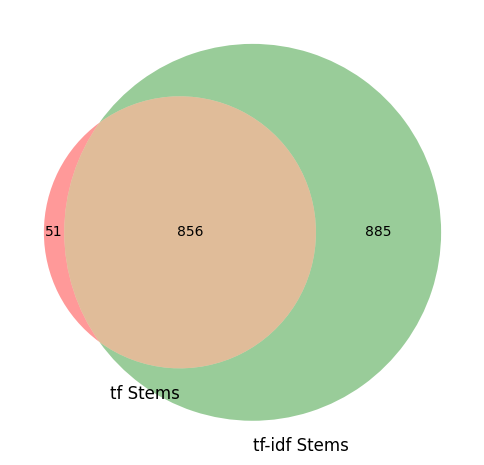

In [61]:
set_stems_tf = set(all_top_stems_tf)
set_stems_tfidf = set(all_top_stems_tfidf)

plt.figure(figsize=(6, 6))
venn2([set_stems_tf, set_stems_tfidf], ('tf Stems', 'tf-idf Stems'))
plt.savefig("intersection2.png")
plt.show()

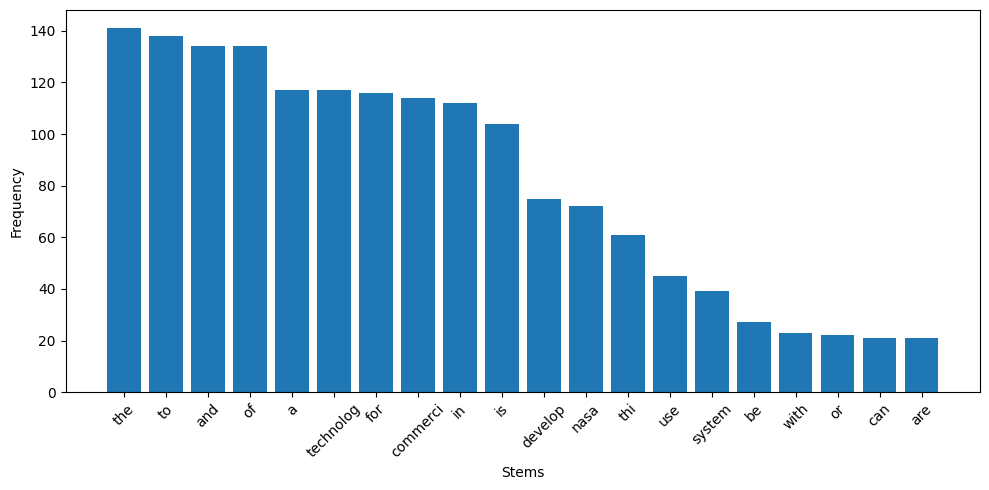

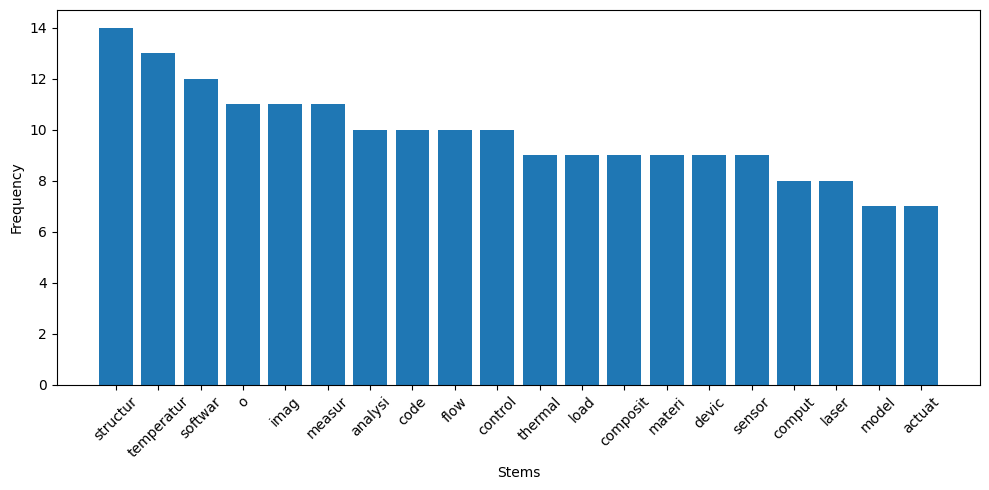

In [62]:
stem_labels_tf, stem_counts_tf = zip(*top_common_stems_tf)
plt.figure(figsize=(10, 5))
plt.bar(stem_labels_tf, stem_counts_tf)
plt.xlabel('Stems')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

stem_labels_tfidf, stem_counts_tfidf = zip(*top_common_stems_tfidf)
plt.figure(figsize=(10, 5))
plt.bar(stem_labels_tfidf, stem_counts_tfidf)
plt.xlabel('Stems')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Clustering

In [71]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


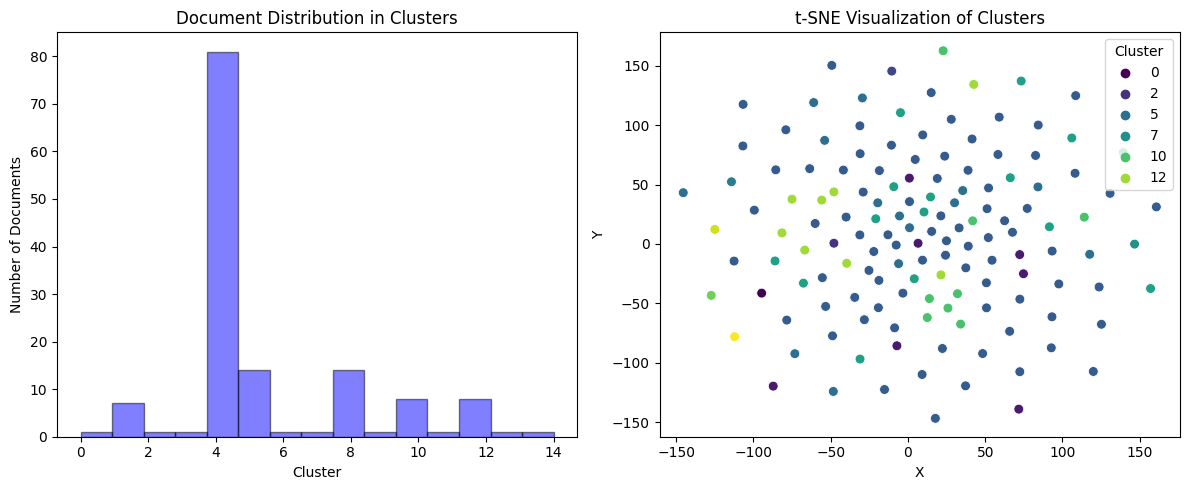

In [72]:
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(vector_model.matrix.T)
cluster_labels = kmeans.labels_

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(cluster_labels, bins=n_clusters, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('Document Distribution in Clusters')

tsne = TSNE(n_components=2, random_state=42)
embedded_docs = tsne.fit_transform(vector_model.matrix.T)
embedded_df = pd.DataFrame({'X': embedded_docs[:, 0], 'Y': embedded_docs[:, 1], 'Cluster': cluster_labels})

plt.subplot(122)
sns.scatterplot(data=embedded_df, x='X', y='Y', hue='Cluster', palette='viridis', s=50)
plt.title('t-SNE Visualization of Clusters')

plt.tight_layout()
plt.show()